## Imports

In [34]:
import torch
from torch import nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pickle as pkl
%matplotlib inline

## Get and load the data

In [4]:
# transforms
transform = transforms.ToTensor()
# get data
train = datasets.FashionMNIST('../data/data/', download=True,train=True, transform=transform)
test = datasets.FashionMNIST('../data/data/', download=True, train=False, transform=transform)

# dataloaders
train_loader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=32)
test_loader = torch.utils.data.DataLoader(test, shuffle=False, batch_size=32)
classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

## Visualize

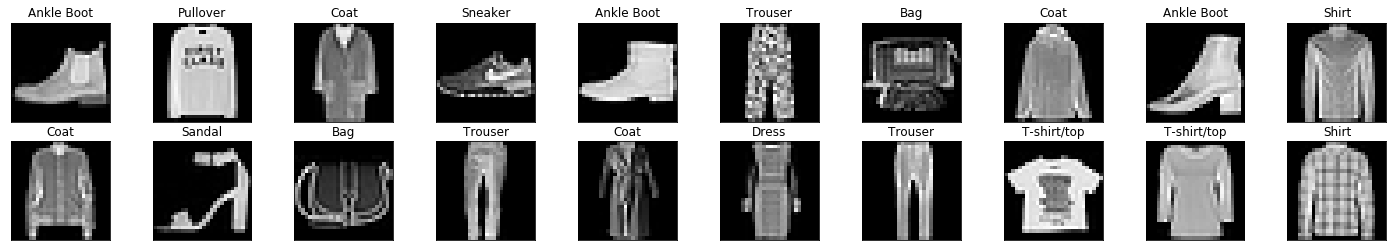

In [15]:
# visualize
# load a batch
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
# visualize
fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [25]:
## Generator
class Generator(nn.Module):
    def __init__(self,input_size=100, hidden_dim=32, output_size=784):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.out = nn.Linear(hidden_dim*4, output_size)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = F.tanh(self.out(x))
        
        return x
G = Generator()
G

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [26]:
## Discriminator

class Discriminator(nn.Module):
    def __init__(self,input_size=784, hidden_dim=32, output_size=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(0.4)
    def forward(self, x):
        #flatten
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.out(x)
        return x
D = Discriminator()
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

## Discriminator and Generator losses

In [43]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    if(smooth):
        loss = criterion(D_out.squeeze(), labels*0.9)
    else:
        loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

## Optimizers

In [33]:
d_optimizer = optim.Adam(D.parameters(), lr=0.002)
g_optimizer = optim.Adam(G.parameters(), lr=0.002)

## Train the generator and discriminator

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [ ]:
epochs = 100
samples = []
losses = []
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
fixed_z = np.random.uniform(-1,1, size=(16,100)) # Size of latent vector to give to generator z_size = 100
fixed_z = torch.from_numpy(fixed_z).float()
## set to training mode
D.train()
G.train()
for epoch in range(epochs):
    for real_images, _ in train_loader:
        batch_size = real_images.size(0) # or .shape[0]
        #rescale images from [0,1] to [-1,1]
        real_images = real_images*2 - 1
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        d_optimizer.zero_grad()
        # 1. Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, True)
        # 2. Train with fake images
        z = np.random.uniform(-1,1, size=(batch_size,100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        #fake loss
        D_fake = D(fake_images)
        d_f_loss = fake_loss(D_fake)
        # sum loss and backprop
        d_loss = d_real_loss + d_f_loss
        d_loss.backward()
        d_optimizer.step()
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        # Train with fake images and flipped labels
        z = np.random.uniform(-1,1, size=(batch_size,100))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        # discriminator loss on fake images
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) #using real loss to flip the images
        g_loss.backward()
        g_optimizer.step()
        
    print(f'Epoch: {epoch+1}, \t D Loss: {d_loss.item():6f}, \t G Loss: {g_loss.item():6f}')
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss    
    losses.append((d_loss.item(), g_loss.item()))
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch: 1, 	 D Loss: 1.230820, 	 G Loss: 0.921491
Epoch: 2, 	 D Loss: 1.361232, 	 G Loss: 1.039235
Epoch: 3, 	 D Loss: 1.286093, 	 G Loss: 0.826924
Epoch: 4, 	 D Loss: 1.436589, 	 G Loss: 0.827780
Epoch: 5, 	 D Loss: 1.388883, 	 G Loss: 0.883026
Epoch: 6, 	 D Loss: 1.358666, 	 G Loss: 0.859171
Epoch: 7, 	 D Loss: 1.360344, 	 G Loss: 0.999225
Epoch: 8, 	 D Loss: 1.418062, 	 G Loss: 0.929824
Epoch: 9, 	 D Loss: 1.358727, 	 G Loss: 0.838459
Epoch: 10, 	 D Loss: 1.219083, 	 G Loss: 1.016197
Epoch: 11, 	 D Loss: 1.362347, 	 G Loss: 0.787480
Epoch: 12, 	 D Loss: 1.258725, 	 G Loss: 1.038321
Epoch: 13, 	 D Loss: 1.394518, 	 G Loss: 0.799728
Epoch: 14, 	 D Loss: 1.331436, 	 G Loss: 0.877079
Epoch: 15, 	 D Loss: 1.290754, 	 G Loss: 0.837829
Epoch: 16, 	 D Loss: 1.320276, 	 G Loss: 0.785341
Epoch: 17, 	 D Loss: 1.278273, 	 G Loss: 0.821164
Epoch: 18, 	 D Loss: 1.345068, 	 G Loss: 1.003495
Epoch: 19, 	 D Loss: 1.383089, 	 G Loss: 0.954100
Epoch: 20, 	 D Loss: 1.369367, 	 G Loss: 0.819729


In [53]:
images.size()

torch.Size([32, 1, 28, 28])